# Machine Learning Pipelines

# Models as a task graph (DAG)
<img src="../part_1/img/rolson17-ml-pipeline.png">
<div style="text-align: right">Source: R. Olson et. al. (2017) "Data-driven Advice for Applying Machine Learning to Bioinformatics Problems."</div>

# Why a DAG?

### Encapsulation

Feature engineering operators, post-processing (e.g. calibration) are part of your model.

### Optimization

Feature engineering operators have hyper-parameters too. Furthermore, we want to search over graphs.

### Safety

Ensure that no information from testing can "leak" into the model fitting phase.

### Train-test-skew

Contracts between operators are more subtle than just message schemas; assumptions about the data distribution are included as well. Operators must not change after the model was fit!

# Pipelines in Scikit-learn

### [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline)

A linear sequence of `Estimator` objects that represent a fixed set of steps, often feature extraction, normalization and classification. It implements the [Composite design pattern (GoF)](https://en.wikipedia.org/wiki/Composite_pattern).

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a `transform` method).

Pipelines allow nested parameters:
```python

est = Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])
est.set_params(scaler__with_std=False)
```

### Exercise 2.1.1

Build a `Pipeline` version of the `PolynomialRegressor` and search for the optimal `degree` of the polynomial.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%run ../part_1/utils.py

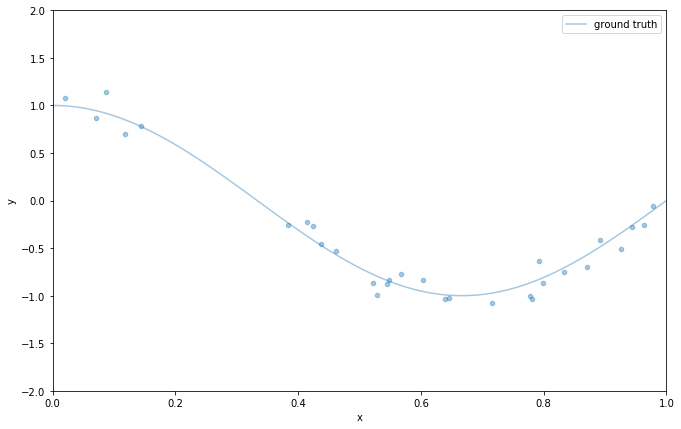

In [2]:
X, y = generate_curve_data()
fig = plot_data(X, y, fn=true_fn)

{'lr__n_jobs': 1, 'poly__degree': 3}


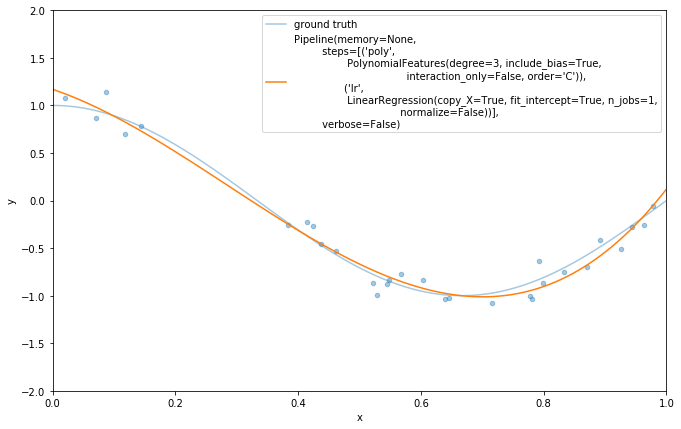

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Excercise: change this estimator to polynomial regression
est = Pipeline(steps=[('poly', PolynomialFeatures()), ('lr', LinearRegression())])

gs = GridSearchCV(estimator=est, param_grid={'poly__degree': [2,3,4,5,6,7,8,9], 'lr__n_jobs': [1,2,3,5]}, 
                  scoring='neg_mean_squared_error', cv=3)

gs.fit(X[:, np.newaxis], y)

fig = plot_data(X, y, fn=true_fn)
plot_estimator(gs.best_estimator_, fig)
print(gs.best_params_)

# Beyond a chain of estimators


### [FeatureUnion](https://scikit-learn.org/stable/modules/compose.html#featureunion-composite-feature-spaces)

Combines several transformer objects into a new transformer that combines their output.
Takes a list of transformer objects, each of which is fit to the data independently. 
The transformers are applied in parallel, and the feature matrices they output are concatenated side-by-side into a wider matrix (via `np.hstack`).

```python
feature_extractors = [('poly', PolynomialFeatures()), ('pca', PCA())]
est = Pipeline(steps=[('fu_1', FeatureUnion(feature_extractors)), 
                      ('rfe', RFE(LinearRegression(), 5, step=1)), 
                      ('lr', LinearRegression())])
```

### Caching of transformers

Pipelines can do [caching](https://scikit-learn.org/stable/modules/compose.html#caching-transformers-avoid-repeated-computation) via `memory` which helps to avoid repeated computation. 

# Working with heterogenous data sources

### [ColumnTransformer](https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data)

Many datasets contain features of different types, say text, numeric, categorical, and dates, where each type of feature requires separate preprocessing or feature extraction steps.

This component is still experimental in 0.21.

```python
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(dtype='int'),['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder='drop')
```

# Kaggle Time!

### Dataset

[Blue Book for Bulldozers (aka Fastiron) Kaggle competition](https://www.kaggle.com/c/bluebook-for-bulldozers/data). 

Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.

Performance metric: mean absolute error (MAE).

In [2]:
df.pop(??

SyntaxError: invalid syntax (<ipython-input-2-ed6c39d0a656>, line 1)

In [4]:
import pandas as pd
import numpy as np

url = 'https://s3.amazonaws.com/datarobot_public_datasets/fastiron-train-sample_80.csv'
df = pd.read_csv(url, parse_dates=['saledate'])
df['saledate'] = df['saledate'].astype(np.int64)
target_feature = 'SalePrice'
categorical_features = ['UsageBand', 'fiBaseModel', 'fiModelDesc', 
                        'fiModelSeries', 'ProductSize',
                        'state', 'ProductGroup', 'ProductGroupDesc','Enclosure',
                        'Enclosure_Type', 'Tire_Size',
                        ]
numeric_features = ['MachineID', 'ModelID', 'datasource', 'YearMade', 'saledate']
text_features = ['fiProductClassDesc']

y = df.pop(target_feature)
X = df

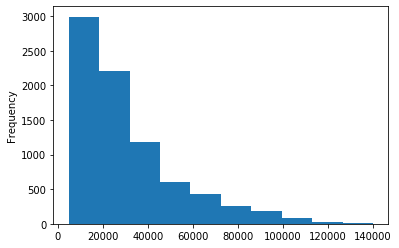

In [5]:
y.plot.hist(50)

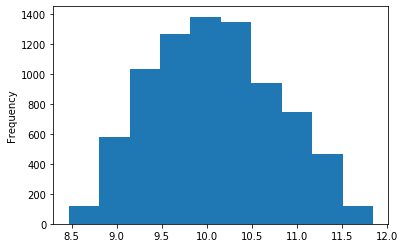

In [6]:
y_log1p = np.log1p(y)
y_log1p.plot.hist(50)

# Example Pipeline

<img src="img/pipeline-example.png">


In [19]:
import utils
from utils import ColumnGroupSelector
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

# y should be an ndarray
y_train = y_train.values
y_test = y_test.values


numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

## Categorical pipeline
# categorical_pipeline = Pipeline(steps=[...])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ## ('cat', categorical_pipeline, categorical_features),
    ])

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lr', LinearRegression())])

est.fit(X_train, y_train)
print("model score: %.3f" % mean_absolute_error(y_test, est.predict(X_test)))

model score: 16845.013


# Exercise 2.1.2

Implement the following pipeline:

<img src="img/exercise_2_1_2.png">

Tune hyper-parameters:
  * `RandomForestRegressor(criterion='mse')` with `['mse', 'mae']`
  * Set `RandomForestRegressor(n_estimators=10)` to avoid long runtime
  * Set `SelectFromModel`s model to `ElasticNet(alpha=0.1)` and select `max_features=100` and `threshold=None`

In [28]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet


numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-99999)),
    ])

categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value="missing_value")),
        ('one_hot', OneHotEncoder(handle_unknown='ignore')),
        ('select_feature', SelectFromModel(ElasticNet(alpha=0.1), threshold=None))
    ])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
    ])

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor(n_estimators=10, n_jobs=-1))])

gs = GridSearchCV(estimator=est, param_grid={'rf__criterion': ['mse', 'mae']}, 
                  scoring='neg_mean_absolute_error', cv=3, refit=True, verbose=10)

gs.fit(X_train, y_train)

print("best params: {}".format(gs.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, gs.best_estimator_.predict(X_test)))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] rf__criterion=mse ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... rf__criterion=mse, score=-7624.358, total=   3.7s
[CV] rf__criterion=mse ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] ............... rf__criterion=mse, score=-7495.794, total=   3.6s
[CV] rf__criterion=mse ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV] ............... rf__criterion=mse, score=-7794.208, total=   3.5s
[CV] rf__criterion=mae ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s


[CV] ............... rf__criterion=mae, score=-7766.502, total=  33.7s
[CV] rf__criterion=mae ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   44.5s remaining:    0.0s


[CV] ............... rf__criterion=mae, score=-7650.819, total=  35.9s
[CV] rf__criterion=mae ...............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV] ............... rf__criterion=mae, score=-7785.364, total=  36.8s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.0min finished


best params: {'rf__criterion': 'mse'}
model score: 7146.492


# Exercise 2.1.3

Add a sub-pipeline to process text:

<img src="img/exercise_2_1_3.png">

Notes:
* `RandomForestRegressor` is not doing great with wide & sparse Bag-of-Words representations; you can use a sub-model to predict the `SalePrice` just from BoW features and feed this predictions into the `RandomForestRegressor`.

In [29]:

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import KFold
    

class StackingTransformer(BaseEstimator, TransformerMixin):
    """A transformer that wraps a RegressorMixin `est` predict function.
    
    It overloads `fit_transform` to do a stacked transform to avoid leakage.
    """
    def __init__(self, est):
        self.est = est
        
    def fit(self, X, y=None):
        if y is None:
            raise ValueError('{}.fit requires y to be not None'.format(self))
        self.est.fit(X, y)
        return self
    
    def transform(self, X):
        return self.est.predict(X)[:, np.newaxis]
    
    def fit_transform(self, X, y=None):
        if y is None:
            raise ValueError('{}.fit requires y to be not None'.format(self))
        self.models_ = []
        out = np.empty_like(y)[:, np.newaxis]
        for train, test in KFold(5, shuffle=True, random_state=0).split(X):
            self.models_.append(clone(self.est).fit(X[train], y[train]))
            out[test, 0] = self.models_[-1].predict(X[test])
        self.est = self.models_[0]
        return out


numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-99999)),
    ])


categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value="missing_value")),
        ('one_hot', OneHotEncoder(handle_unknown='ignore')),
        ('select_feature', SelectFromModel(ElasticNet(alpha=0.1), threshold=None))
    ])


text_pipeline = Pipeline(steps=[
    ('bow', CountVectorizer()),
    ('bow_reg', StackingTransformer(ElasticNet(alpha=0.1)))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('text', text_pipeline, text_features[0])
    ])

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor(n_estimators=10, criterion='mae', n_jobs=-1))])

est.fit(X_train, y_train)

print("model score: %.3f" % mean_absolute_error(y_test, est.predict(X_test)))

model score: 6834.263
